In [ ]:
%run "10_Data into model format.ipynb"

In [5]:
%run "10_Data into model format.ipynb"
model_name = 'model20220813_100run'
model1, model2  =model_name,model_name
data_from = '/val_pred/v'#'/sub/subgp'   '/sub/subm'  'val_perd'
n=10#100
major_save_path1 = Huge_data_path+'Model/'+model1+data_from
major_save_path2 = Huge_data_path+'Model/'+model2+data_from
share_value = -1.5
update_count = 100
def value_pointing(x1,x2,value):
    if (x1!=x2):
        
        return np.clip((value-x1)/(x2-x1),0,1)
        #return np.clip((value-(x1+x2)/2)/((x1-x2)/2),0,1)
    else:
        return share_value #0.5 for 2 model mean, 1 for always keep major(x1) model value

def value_pointing(x1,x2,value,x1min,x1max,x2min,x2max):
        if (x1==x2):
            return -1
        if (x1!=x2):
            if value > x1max:
                return np.clip((value-x1max)/(x2max-x1max),0,1)
            if value < x1min: 
                return np.clip((value-x1min)/(x2min-x1min),0,1)
    
        return 0 #0.5 for 2 model mean, 0 for always keep major(x1) model value

#version1,version2 = '_gp18','_gp19'
def gen_comparsion_v(version1,version2,major_save_path1,major_save_path2):
    val_info1, val_info2= pd.read_csv(major_save_path1+version1+'.csv').set_index('customer_ID'),pd.read_csv(major_save_path2+version2+'.csv').set_index('customer_ID')
    #cut_list = [0,0.002,0.003,0.004,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.975,0.99,1]
    #cut_list = [0,0.002,0.003,0.004,0.005,0.01,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.9,0.95,0.975,0.99,1]
    cut_list = [0,0.002,0.003,0.004,0.005,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.96,0.97,0.98,0.99,1]
    gp_gap = [element1 - element2 for (element1, element2) in zip(cut_list[1:], cut_list[:-1])]

    #check
    #print((val_info1['target']-val_info2['target']).agg([min,max,sum]),val_info1['target'].isna().sum(),val_info2['target'].isna().sum())

    val_info1['pred_gp'] = pd.cut(val_info1["prediction_test"], cut_list).apply(lambda x: x.mid).astype('float32').round(5).astype('str')
    val_info1['pred_gp_min'] =  pd.cut(val_info1["prediction_test"], cut_list).apply(lambda x: x.left).astype('float32').round(5)
    val_info1['pred_gp_max'] =  pd.cut(val_info1["prediction_test"], cut_list).apply(lambda x: x.right).astype('float32').round(5)

    val_info2['pred_gp'] = pd.cut(val_info2["prediction_test"], cut_list).apply(lambda x: x.mid).astype('float32').round(5).astype('str')
    val_info2['pred_gp_min'] =  pd.cut(val_info2["prediction_test"], cut_list).apply(lambda x: x.left).astype('float32').round(5)
    val_info2['pred_gp_max'] =  pd.cut(val_info2["prediction_test"], cut_list).apply(lambda x: x.right).astype('float32').round(5)

    val = pd.concat([val_info1[['prediction_test','pred_gp','pred_gp_min','pred_gp_max']].add_suffix('_'+version1),
                    val_info2[['prediction_test','pred_gp','pred_gp_min','pred_gp_max']].add_suffix('_'+version2)],axis=1)
    val = pd.concat([val,val_info1['target']],axis=1)
    display(val)
    val = val[abs(val['prediction_test_'+version1]-val['prediction_test_'+version2])>(val['pred_gp_max_'+version1]-val['pred_gp_min_'+version1])/5]
    #T1
    Cross_table = pd.pivot_table(val,index='pred_gp_'+version1,columns='pred_gp_'+version2,values='target',aggfunc=[np.mean,'count'])#,margins = True, margins_name='Total')
    review_val = val[val['prediction_test_'+version1].between(0.1, 0.9, inclusive=False)]
    review_val['diff'] = review_val['prediction_test_'+version1]-review_val['prediction_test_'+version2]
    display(
        review_val[
            (review_val['diff']>0.01) | (review_val['diff']< -0.01)
            ]['diff'].describe()
        )
    #T2
    pre_gp_ref = ['pred_gp_'+version1,'pred_gp_min_'+version1,'pred_gp_max_'+version1,
                'pred_gp_'+version2,'pred_gp_min_'+version2,'pred_gp_max_'+version2]
    val_gp = val.groupby(pre_gp_ref).agg([np.mean,'count']).reset_index()#.astype('float32')
    val_gp.columns = [''.join(x) for x in val_gp.columns]
    #display(val_gp)
    val_gp['val_p'] = val_gp.apply(lambda x: 
                                    value_pointing(
                                    x['pred_gp_'+version1],x['pred_gp_'+version2],x['targetmean'],
                                    x['pred_gp_min_'+version1],x['pred_gp_max_'+version1],
                                    x['pred_gp_min_'+version2],x['pred_gp_max_'+version2]) 
                                    if x['targetcount'] >= update_count else share_value
                                    , axis=1)
    #display(val_gp[val_gp['val_p']==-1])
    Cross_tableII = pd.pivot_table(val_gp,index='pred_gp_'+version1,columns='pred_gp_'+version2,values='val_p',aggfunc=[np.mean])
    
    fig, ax = plt.subplots(3,1,figsize=(30, 30))
    sns.heatmap(Cross_table['mean'],annot=True,ax = ax[0])
    #sns.heatmap((Cross_table['mean']-(Cross_table['mean'].index.astype('float'))),annot=True,ax = ax[1], vmin=-0.05, vmax=0.05,center=0)#/gp_gap
    sns.heatmap(Cross_tableII,annot=True,ax = ax[1],center=0)
    sns.heatmap(Cross_table['count'].fillna(0).astype(int),ax = ax[2],annot=True, vmin=0, vmax=700,fmt="d")
    plt.show()
    plt.close(fig)


function: load_DProcessed_df(file), amex_metric(y_true, y_pred), file_get(dataset,version,dataset_list,num_list_inModel,ignore_list)
list:all_cols,cat_list,num_list , varible: Huge_data_path


,prediction_test_v0,pred_gp_v0,pred_gp_min_v0,pred_gp_max_v0,prediction_test_v1,pred_gp_v1,pred_gp_min_v1,pred_gp_max_v1,target
customer_ID,,,,,,,,,
eced0c97461ba4d36792d56fc1cde8d9cd04d4eb27eac2d3f5fcdacf9eaefe22,0.000587,0.001,0.000,0.002,0.001260,0.001,0.000,0.002,0
0b1cdc9b19b99810c8d46feadd48d923de992b0505b5932d9d6fbf457647a223,0.001701,0.001,0.000,0.002,0.003537,0.0035,0.003,0.004,0
b484adc9ea89f4129e02614aa803729ac1bc27359a0acafd8d3a07a204e9a3b6,0.009804,0.0075,0.005,0.010,0.012285,0.03,0.010,0.050,0
e54e0057094150157ce2359826398e27ecde40b1bea32381a11c6a5244660a82,0.168349,0.175,0.150,0.200,0.257366,0.275,0.250,0.300,0
af3dd719da0309fedbd8d3c73751960cb0af7539957cf0156a3a1ae471ea3b29,0.039109,0.03,0.010,0.050,0.060786,0.075,0.050,0.100,0
...,...,...,...,...,...,...,...,...,...
024a5c9f77ee216c85d427e58a517a085250af47accd2da5335ad10016fd61b3,0.744374,0.725,0.700,0.750,0.666391,0.675,0.650,0.700,0
5e9c912fd9144515fdd462e404ab53a2730835ed0bcf40e5d040c158f11d1c96,0.006414,0.0075,0.005,0.010,0.001980,0.001,0.000,0.002,0
39f24f9c879057e150c5832722b5d99f0b6590fe824bcfd55eec7ce88e6e9aab,0.001885,0.001,0.000,0.002,0.002820,0.0025,0.002,0.003,0


count    22118.000000
mean         0.002107
std          0.082016
min         -0.358340
25%         -0.050445
50%          0.012858
75%          0.054367
max          0.382020
Name: diff, dtype: float64

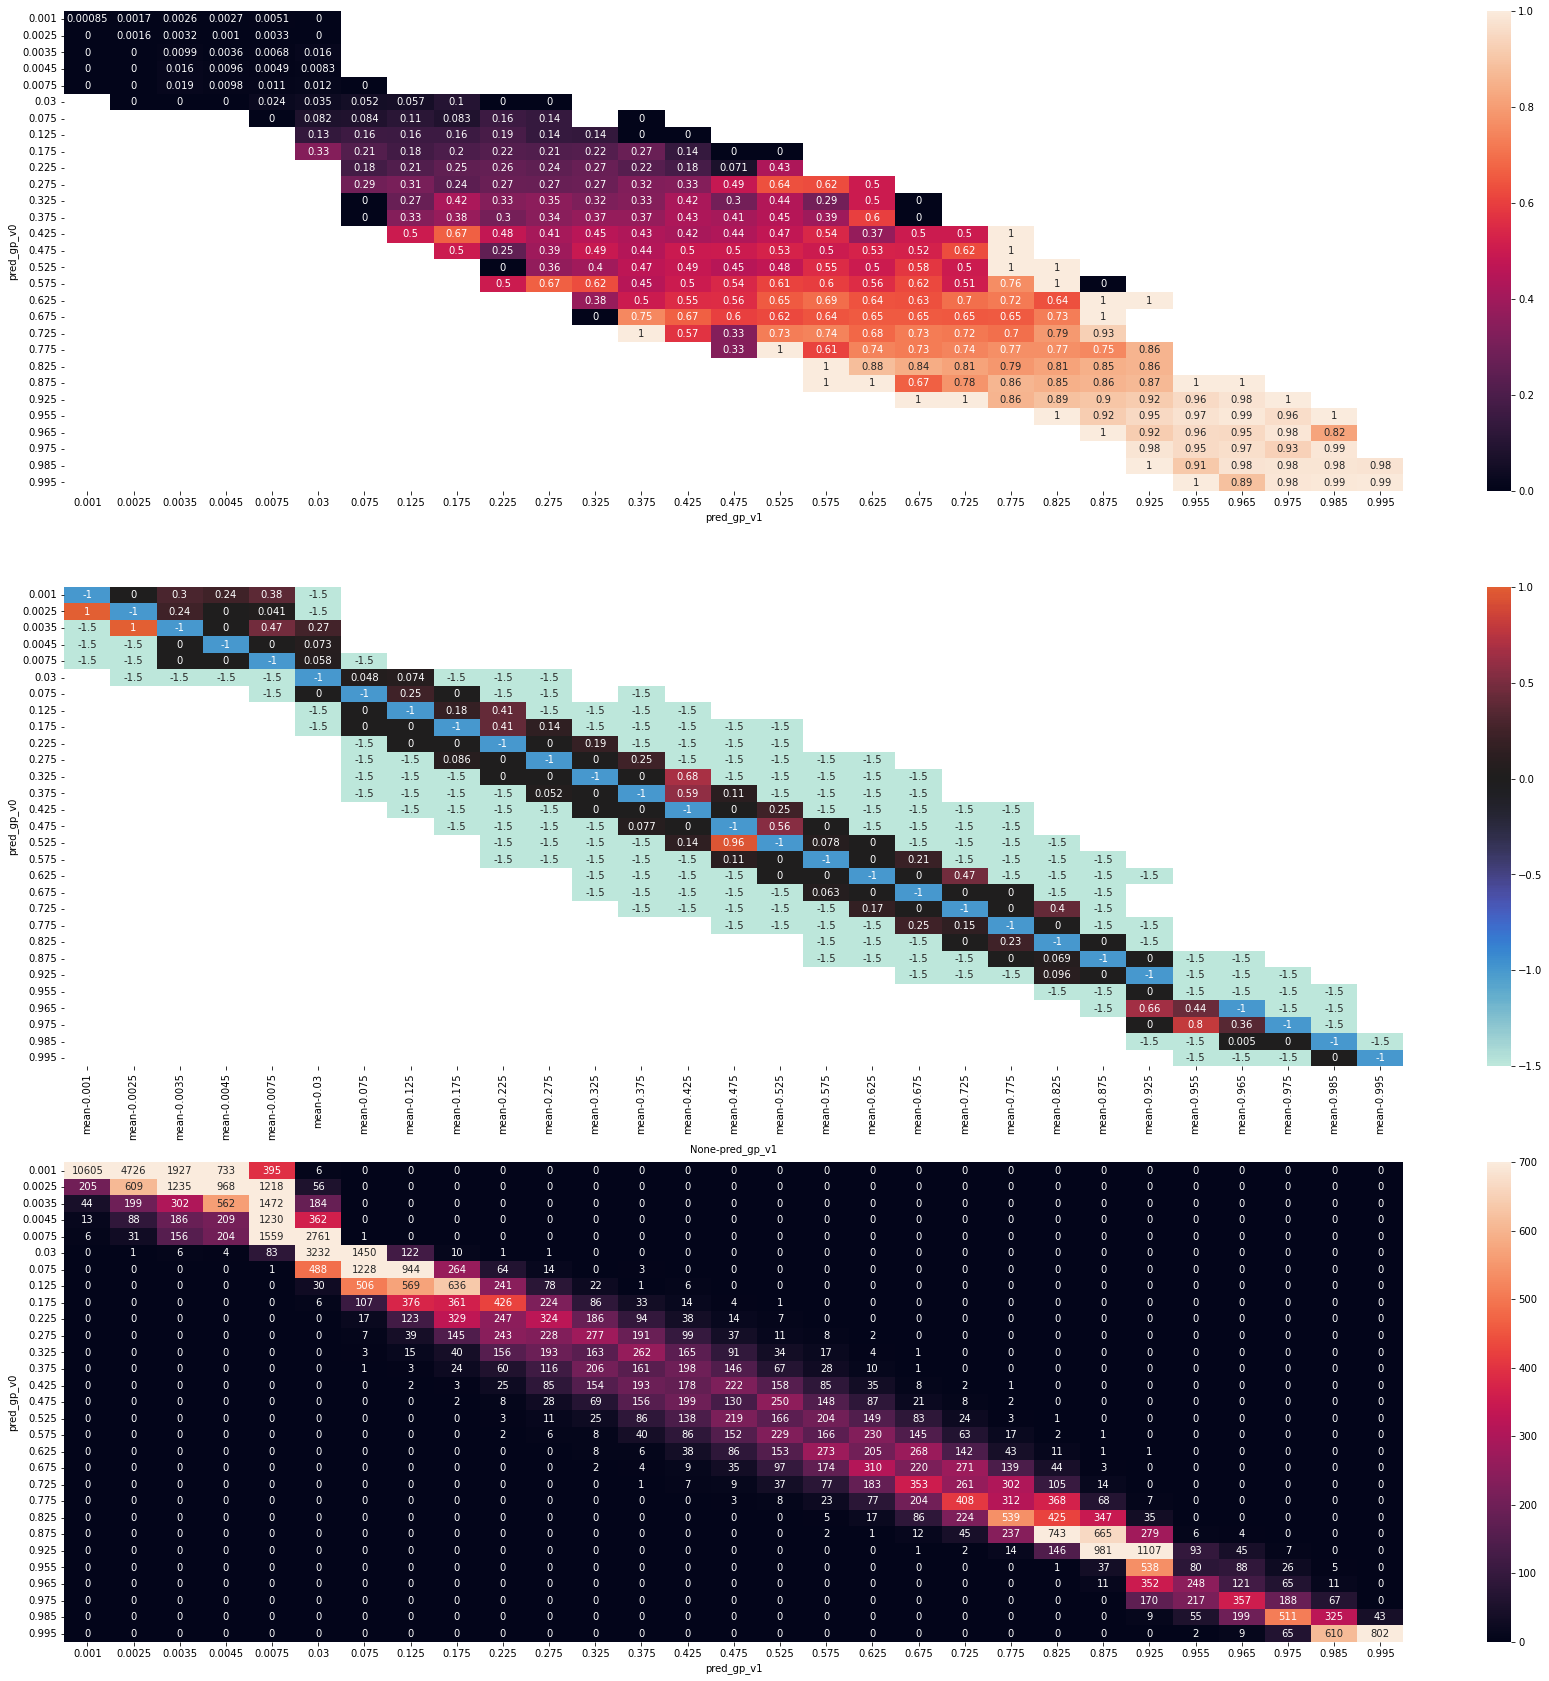

In [7]:
gen_comparsion_v('v0','v1','../huge data source/AE/Model/model20220816_hldart_over0/val_pred/','../huge data source/AE/Model/model20220818_hl_featuresplit_seed11/val_pred/')

function: load_DProcessed_df(file), amex_metric(y_true, y_pred), file_get(dataset,version,dataset_list,num_list_inModel,ignore_list)
list:all_cols,cat_list,num_list , varible: Huge_data_path
min    0
max    0
sum    0
Name: target, dtype: int64 0 0
min    0
max    0
sum    0
Name: target, dtype: int64 0 0


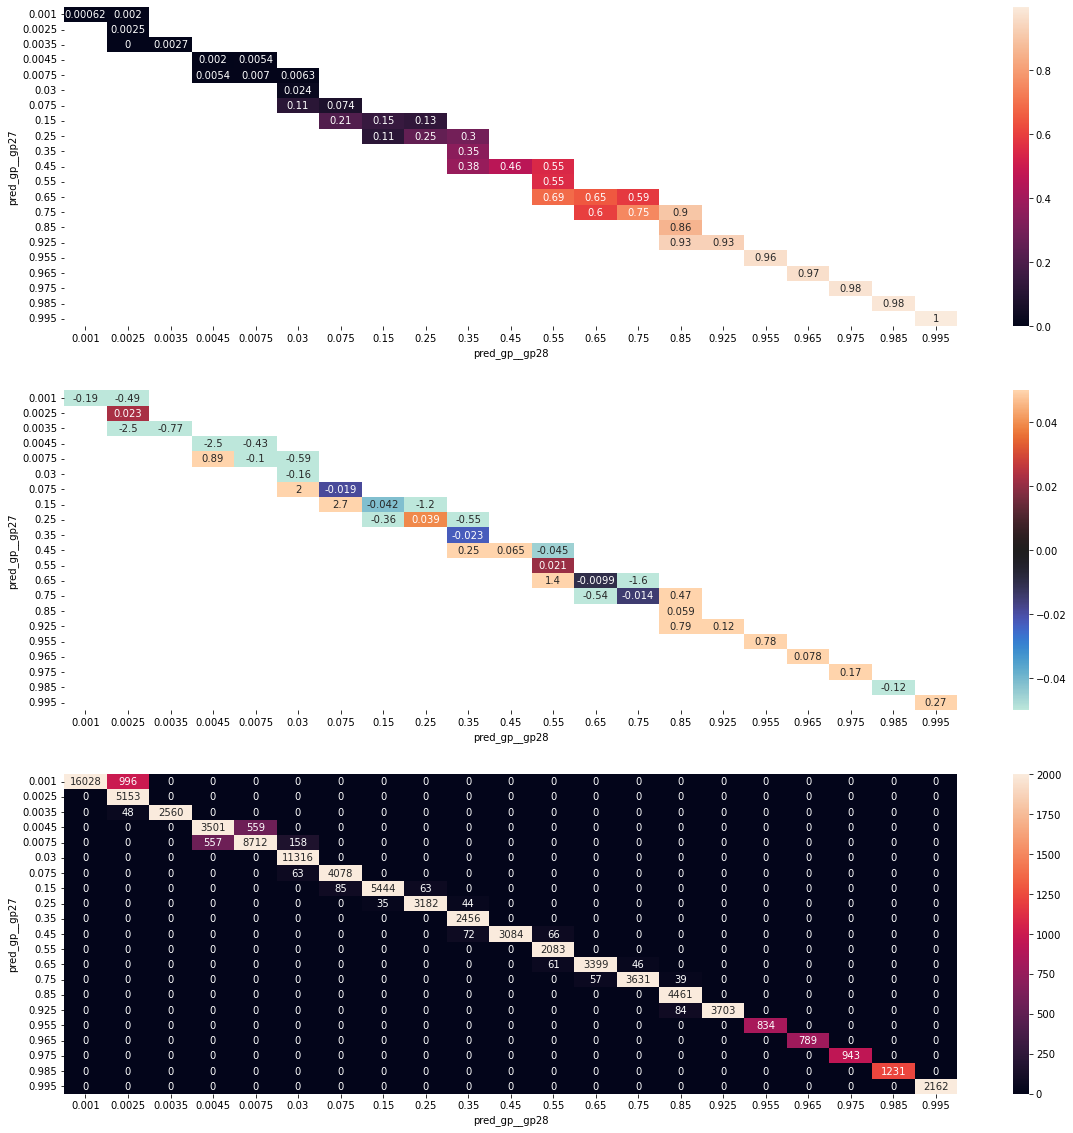

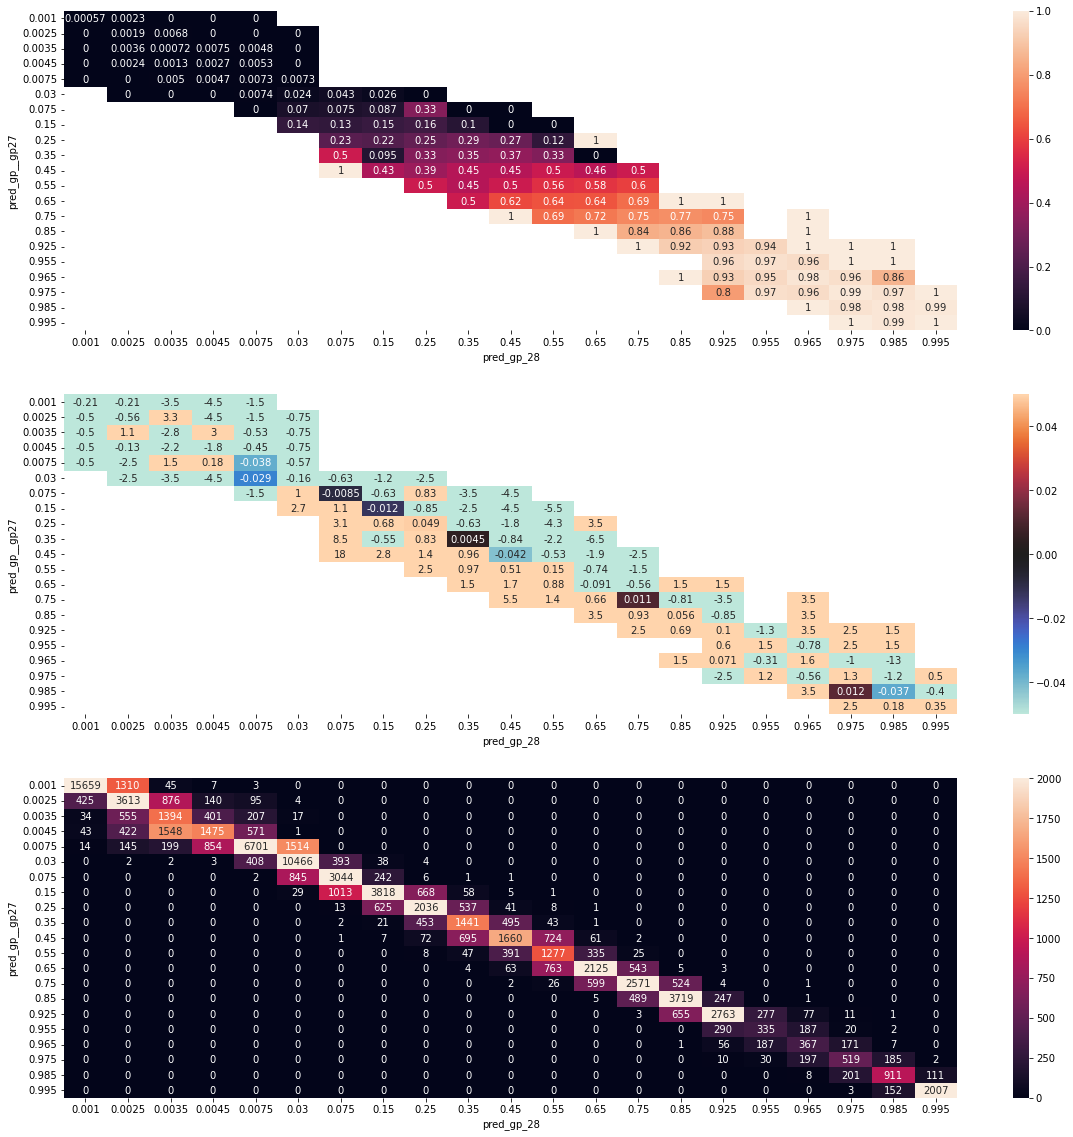

In [61]:
gen_comparsion('_gp27','_gp28',major_save_path1,major_save_path2)
gen_comparsion('_gp27','28',major_save_path1,major_save_path2)

In [5]:
aa = pd.read_csv(Huge_data_path+'Model/'+'model20220819_hl_featuresplit_seedtrail/preformace_record.csv')
aa#.groupby('seed').mean()

,th,seed,time,train_g,train_d,train_score,train_d_p,test_g,test_d,test_score,test_d_p,model_params,top_item
0,0,0,08/19/2022 13:12:01,0.984270,0.917741,95.100565,0.504424,0.920988,0.650084,78.553587,0.720313,NaN,D_43_f-3avg
1,1,0,08/19/2022 13:16:58,0.984073,0.917446,95.075978,0.504676,0.921517,0.652467,78.699169,0.717124,NaN,P_2_mean
2,2,0,08/19/2022 13:22:06,0.984712,0.921735,95.322318,0.498049,0.921103,0.653804,78.745379,0.715271,NaN,D_43_f-6avg
3,3,0,08/19/2022 13:27:17,0.985670,0.924727,95.519849,0.495676,0.920962,0.649415,78.518830,0.716670,NaN,P_2_max
4,0,1,08/19/2022 13:32:42,0.987469,0.934465,96.096715,0.484878,0.922030,0.661081,79.155567,0.710901,NaN,S_3_f-6avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,14,08/19/2022 18:26:31,0.984208,0.917751,95.097940,0.506650,0.922985,0.666088,79.453643,0.708442,NaN,P_2_mean
58,2,14,08/19/2022 18:31:57,0.983165,0.914253,94.870908,0.509610,0.922660,0.662914,79.278726,0.710991,NaN,D_43_f-6avg
59,3,14,08/19/2022 18:37:39,0.985693,0.925472,95.558253,0.498947,0.922538,0.664480,79.350911,0.709303,NaN,P_2_max
60,0,15,08/19/2022 18:43:36,0.987909,0.936221,96.206500,0.480458,0.923322,0.662873,79.309754,0.711960,NaN,S_3_f-6avg


In [5]:

%run "10_Data into model format.ipynb"
model_name = 'model20220813_lowdart'
model1, model2  = model_name,model_name
data_from = '/sub/model20220813_lowdart_sub'#'/sub/subgp'   '/sub/subm'
n=10#100
major_save_path1 = Huge_data_path+'Model/'+model1+data_from
major_save_path2 = Huge_data_path+'Model/'+model2+data_from

#above protental update

version1,version2 = 'm2','m3'
def gen_comparsion_s(version1,version2,major_save_path1,major_save_path2):
    val_info1, val_info2= pd.read_csv(major_save_path1+version1+'.csv').set_index('customer_ID'),pd.read_csv(major_save_path2+version2+'.csv').set_index('customer_ID')
    cut_list = [0,0.002,0.003,0.004,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.98,0.99,1]
    gp_gap = [element1 - element2 for (element1, element2) in zip(cut_list[1:], cut_list[:-1])]

    #check
    val_info1['pred_gp'] = pd.cut(val_info1["prediction"], cut_list).apply(lambda x: x.mid).astype('float32').round(5).astype('str')
    val_info2['pred_gp'] = pd.cut(val_info2["prediction"], cut_list).apply(lambda x: x.mid).astype('float32').round(5).astype('str')
    val = pd.concat([val_info1[['prediction','pred_gp']].add_suffix('_'+version1),val_info2[['prediction','pred_gp']].add_suffix('_'+version2)],axis=1)
    Cross_table = pd.pivot_table(val,index='pred_gp_'+version1,columns='pred_gp_'+version2,values = 'prediction_'+version1,aggfunc=['count'])#,margins = True, margins_name='Total')

    fig, ax = plt.subplots(1,1,figsize=(20, 5))
    #sns.heatmap(Cross_table['mean'],annot=True,ax = ax[0])
    #sns.heatmap((Cross_table['mean']-(Cross_table['mean'].index.astype('float')))/gp_gap,annot=True,ax = ax[1], vmin=-0.05, vmax=0.05,center=0)
    sns.heatmap(Cross_table['count'].fillna(0).astype(int),ax = ax,annot=True, vmin=0, vmax=2000,fmt="d")

    #gen_comparsion_s(version1,version2,major_save_path1,major_save_path2)

function: load_DProcessed_df(file), amex_metric(y_true, y_pred), file_get(dataset,version,dataset_list,num_list_inModel,ignore_list)
list:all_cols,cat_list,num_list , varible: Huge_data_path


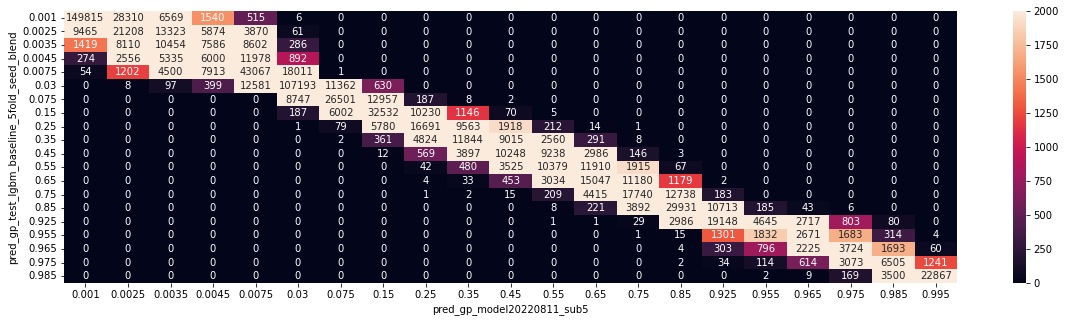

In [6]:
gen_comparsion_s('test_lgbm_baseline_5fold_seed_blend','model20220811_sub5',Huge_data_path,'../huge data source/AE/Model/model20220811/sub/')

function: load_DProcessed_df(file), amex_metric(y_true, y_pred), file_get(dataset,version,dataset_list,num_list_inModel,ignore_list)
list:all_cols,cat_list,num_list , varible: Huge_data_path
min    0
max    0
sum    0
Name: target, dtype: int64 0 0


<AxesSubplot:xlabel='perd_gp__gp1', ylabel='perd_gp_0'>

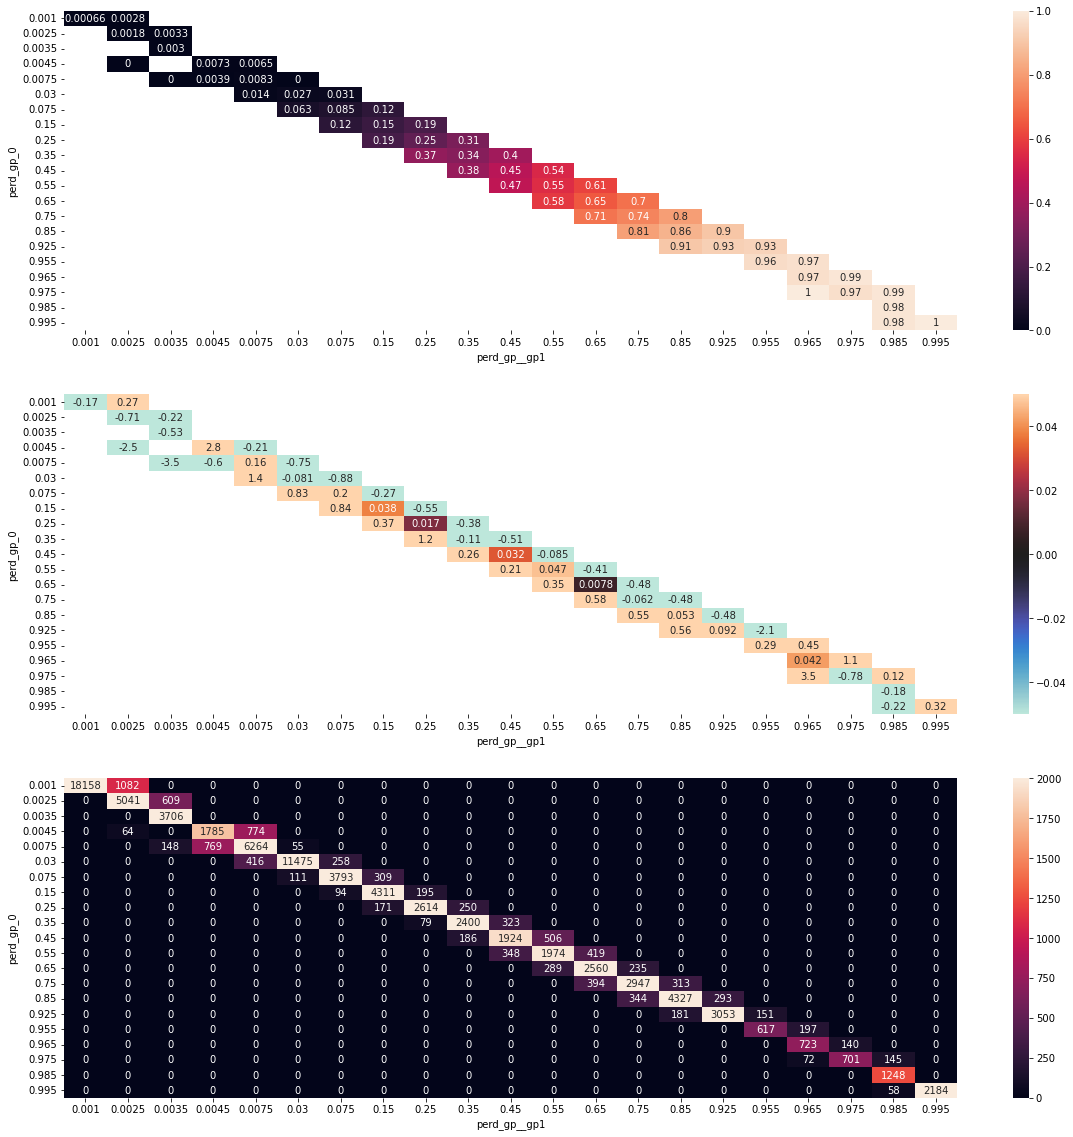

In [26]:
%run "10_Data into model format.ipynb"
version = 'model20220813_lowleaves'
n=10#100
isclear_memory = 1
major_save_path = Huge_data_path+'Model/'+version
#dataset_list =
apply_item_save_path = major_save_path+'/applied_items.pkl'

version1,version2 = '0','_gp1'
val_info1, val_info2= pd.read_csv(major_save_path+'/val_pred/v'+version1+'.csv').set_index('customer_ID'),pd.read_csv(major_save_path+'/val_pred/v'+version2+'.csv').set_index('customer_ID')
cut_list = [0,0.002,0.003,0.004,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.98,0.99,1]
gp_gap = [element1 - element2 for (element1, element2) in zip(cut_list[1:], cut_list[:-1])]

#check
print((val_info1['target']-val_info2['target']).agg([min,max,sum]),val_info1['target'].isna().sum(),val_info2['target'].isna().sum())
val_info1['perd_gp'] = pd.cut(val_info1["prediction_test"], cut_list).apply(lambda x: x.mid).astype('float32').round(5).astype('str')
val_info2['perd_gp'] = pd.cut(val_info2["prediction_test"], cut_list).apply(lambda x: x.mid).astype('float32').round(5).astype('str')
val = pd.concat([val_info1[['prediction_test','perd_gp']].add_suffix('_'+version1),val_info2[['prediction_test','perd_gp']].add_suffix('_'+version2)],axis=1)
val = pd.concat([val,val_info1['target']],axis=1)
Cross_table = pd.pivot_table(val,index='perd_gp_'+version1,columns='perd_gp_'+version2,values='target',aggfunc=[np.mean,'count'])#,margins = True, margins_name='Total')

fig, ax = plt.subplots(3,1,figsize=(20, 20))
sns.heatmap(Cross_table['mean'],annot=True,ax = ax[0])
sns.heatmap((Cross_table['mean']-(Cross_table['mean'].index.astype('float')))/gp_gap,annot=True,ax = ax[1], vmin=-0.05, vmax=0.05,center=0)
sns.heatmap(Cross_table['count'].fillna(0).astype(int),ax = ax[2],annot=True, vmin=0, vmax=2000,fmt="d")


In [ ]:
#version result cross flow

version1,version2 = '',''
val_info1, val_info2= pd.read_csv('Data/Val_pred_'+version1'.csv').set_index('customer_ID'),pd.read_csv('Data/Val_pred_'+version2'.csv').set_index('customer_ID')

#check
print((val_info1['target']-val_info2['target']).agg([min,max,sum]),val_info1['target'].isna().sum(),val_info2['target'].isna().sum())
val_info1['perd_gp'] = (val_info1['prediction_test']*10).astype(int)
val_info2['perd_gp'] = (val_info2['prediction_test']*10).astype(int)
val = pd.concat([val_info1.add_suffix('_'+version1),val_info2.add_suffix('_'+version2)],axis=1)
Cross_table = pd.pivot_table(val,index='perd_gp_'+version1,columns='perd_gp_'+version2,values='target_'+version1,aggfunc=[np.mean,'count'],margins = True, margins_name='Total')
Cross_table

In [33]:
#P_2 vs full

version1,version2 = 'P_2only','full20220803_tune'
val_info1, val_info2= pd.read_csv('Data/Val_pred_'+version1+'.csv').set_index('customer_ID'),pd.read_csv('Data/Val_pred_'+version2+'.csv').set_index('customer_ID')

#check
print((val_info1['target']-val_info2['target']).agg([min,max,sum]),val_info1['target'].isna().sum(),val_info2['target'].isna().sum())
val_info1['perd_gp'] = (val_info1['prediction_test']*10).astype(int)
val_info2['perd_gp'] = (val_info2['prediction_test']*10).astype(int)
val = pd.concat([val_info1.add_suffix('_'+version1),val_info2.add_suffix('_'+version2)],axis=1)
Cross_table = pd.pivot_table(val,index='perd_gp_'+version1,columns='perd_gp_'+version2,values='target_'+version1,aggfunc=[np.mean,'count'],margins = True, margins_name='Total')
Cross_table

min    0
max    0
sum    0
Name: target, dtype: int64 0 0


mean                                          \
perd_gp_full20220803_tune         0         1         2         3         4   
perd_gp_P_2only                                                               
0                          0.009339  0.161430  0.325949  0.403727  0.474747   
1                          0.029701  0.165907  0.235507  0.348315  0.446640   
2                          0.035885  0.165509  0.247019  0.357616  0.433333   
3                          0.052117  0.130496  0.237255  0.324034  0.435768   
4                          0.032010  0.147177  0.229339  0.363636  0.444219   
5                          0.051765  0.148045  0.245232  0.341410  0.449304   
6                          0.073298  0.185714  0.279621  0.343066  0.457831   
7                          0.086420  0.180723  0.213592  0.346154  0.442708   
8                          0.045455  0.138889  0.045455  0.380952  0.426230   
9                          0.000000  0.000000  0.000000  0.500000  0.181818   
Total                      0.014089  0.157212  0.247782  0.350571  0.443910   

                                                                             \
perd_gp_full20220803_tune         5         6         7         8         9   
perd_gp_P_2only                                                               
0                          0.663043  0.767442  0.709677  1.000000  0.937500   
1                          0.650943  0.643836  0.843478  0.949153  0.984375   
2                          0.585987  0.687259  0.753695  0.879032  0.989899   
3                          0.557143  0.586957  0.735465  0.893519  0.985507   
4                          0.538012  0.644161  0.766730  0.856209  0.953307   
5                          0.557439  0.636364  0.749658  0.860027  0.967105   
6                          0.536170  0.658106  0.738186  0.875919  0.948980   
7                          0.558704  0.603730  0.737631  0.857748  0.957706   
8                          0.600000  0.693182  0.780120  0.851410  0.963534   
9                          0.451613  0.651163  0.776596  0.887290  0.975389   
Total                      0.564041  0.641242  0.752289  0.866463  0.966747   

                                     count                                \
perd_gp_full20220803_tune     Total      0     1     2     3     4     5   
perd_gp_P_2only                                                            
0                          0.020015  44867   923   316   161    99    92   
1                          0.150783   4680  1097   552   356   253   212   
2                          0.262096   2090   864   587   453   360   314   
3                          0.340776   1228   705   510   466   397   420   
4                          0.451356    781   496   484   462   493   513   
5                          0.553143    425   358   367   454   503   531   
6                          0.663512    191   210   211   274   332   470   
7                          0.756877     81    83   103   130   192   247   
8                          0.861644     22    36    22    42    61    90   
9                          0.949373      2     5     4     6    11    31   
Total                      0.262162  54367  4777  3156  2804  2701  2920   

                                                          
perd_gp_full20220803_tune     6     7     8     9  Total  
perd_gp_P_2only                                           
0                            43    31    18    16  46566  
1                           146   115    59    64   7534  
2                           259   203   124    99   5353  
3                           368   344   216   138   4792  
4                           548   523   459   257   5016  
5                           682   731   743   456   5250  
6                           623   783  1088   784   4966  
7                           429   667  1181  1395   4508  
8                           176   332   922  1947   3650  
9                            43    94   417 

In [23]:
record_df = pd.read_csv('Model/preformace_record.csv')#.set_index('version')
record_df

,train_g,train_d,train_score,test_g,test_d,test_score,note,version,time,model_params
0,0.937387,0.699924,0.818655,0.919919,0.656055,0.787987,NaN,NaN,NaN,NaN
1,0.937445,0.700019,0.818732,0.919773,0.656014,0.787893,NaN,full20220803_porpnosub,NaN,NaN
2,0.941857,0.733997,0.837927,0.921185,0.659089,0.790137,NaN,full20220803_tune,NaN,NaN
3,0.983898,0.933098,0.958498,0.922210,0.663494,0.792852,NaN,full20220803_tune_overfit,NaN,NaN
4,0.983898,0.933098,0.958498,0.922210,0.663494,0.792852,NaN,full20220803_tune_overfit,08/03/2022 22:48:27,NaN
5,0.993338,0.975054,0.984196,0.922074,0.659588,0.790831,NaN,full20220803_tune_overfit,08/03/2022 23:14:49,NaN
6,0.842397,0.473535,0.657966,0.840646,0.474981,0.657814,NaN,P_2only,08/04/2022 08:55:23,NaN


function: load_DProcessed_df(file), amex_metric(y_true, y_pred), file_get(dataset,version,dataset_list,num_list_inModel,ignore_list)
list:all_cols,cat_list,num_list , varible: Huge_data_path
min    0
max    0
sum    0
Name: target, dtype: int64 0 0


<AxesSubplot:xlabel='perd_gp_full20220808_dart_withoutP2', ylabel='perd_gp_full20220808_dart'>

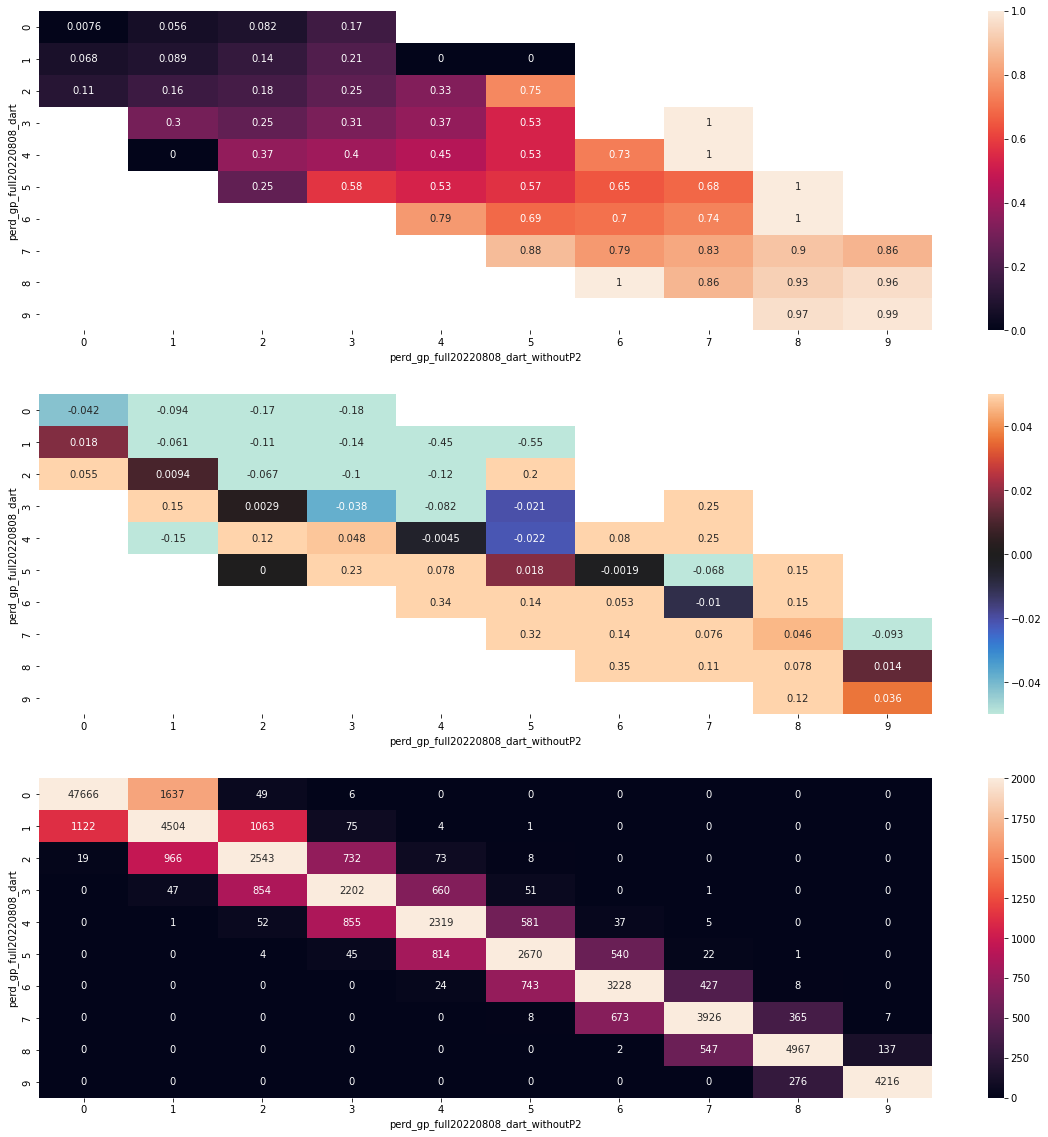

In [7]:
%run "10_Data into model format.ipynb"
version1,version2 = 'full20220808_dart','full20220808_dart_withoutP2'
val_info1, val_info2= pd.read_csv('Data/Val_pred_'+version1+'.csv').set_index('customer_ID'),pd.read_csv('Data/Val_pred_'+version2+'.csv').set_index('customer_ID')

#check
print((val_info1['target']-val_info2['target']).agg([min,max,sum]),val_info1['target'].isna().sum(),val_info2['target'].isna().sum())
val_info1['perd_gp'] = (val_info1['prediction_test']*10).astype(int)
val_info2['perd_gp'] = (val_info2['prediction_test']*10).astype(int)
val = pd.concat([val_info1[['prediction_test','perd_gp']].add_suffix('_'+version1),val_info2[['prediction_test','perd_gp']].add_suffix('_'+version2)],axis=1)
val = pd.concat([val,val_info1['target']],axis=1)
Cross_table = pd.pivot_table(val,index='perd_gp_'+version1,columns='perd_gp_'+version2,values='target',aggfunc=[np.mean,'count'])#,margins = True, margins_name='Total')

fig, ax = plt.subplots(3,1,figsize=(20, 20))
sns.heatmap(Cross_table['mean'],annot=True,ax = ax[0])
sns.heatmap(Cross_table['mean']-(Cross_table['mean'].index.astype('float')*0.1+0.05),annot=True,ax = ax[1], vmin=-0.05, vmax=0.05,center=0)
sns.heatmap(Cross_table['count'].fillna(0).astype(int),ax = ax[2],annot=True, vmin=0, vmax=2000,fmt="d")


In [10]:
Cross_table = pd.pivot_table(val,index='perd_gp_'+version1,columns='perd_gp_'+version2,values='target',aggfunc=[np.mean,'count'],margins = True, margins_name='Total')
Cross_table

mean                                \
perd_gp_full20220808_dart_withoutP2         0         1         2         3   
perd_gp_full20220808_dart                                                     
0                                    0.007574  0.056200  0.081633  0.166667   
1                                    0.067736  0.088810  0.137347  0.213333   
2                                    0.105263  0.159420  0.183248  0.245902   
3                                         NaN  0.297872  0.252927  0.311989   
4                                         NaN  0.000000  0.365385  0.397661   
5                                         NaN       NaN  0.250000  0.577778   
6                                         NaN       NaN       NaN       NaN   
7                                         NaN       NaN       NaN       NaN   
8                                         NaN       NaN       NaN       NaN   
9                                         NaN       NaN       NaN       NaN   
Total                                0.008995  0.092243  0.186637  0.319285   

                                                                             \
perd_gp_full20220808_dart_withoutP2         4         5         6         7   
perd_gp_full20220808_dart                                                     
0                                         NaN       NaN       NaN       NaN   
1                                    0.000000  0.000000       NaN       NaN   
2                                    0.328767  0.750000       NaN       NaN   
3                                    0.368182  0.529412       NaN  1.000000   
4                                    0.445451  0.528399  0.729730  1.000000   
5                                    0.528256  0.568165  0.648148  0.681818   
6                                    0.791667  0.685061  0.702912  0.740047   
7                                         NaN  0.875000  0.790490  0.825777   
8                                         NaN       NaN  1.000000  0.862888   
9                                         NaN       NaN       NaN       NaN   
Total                                0.449153  0.584195  0.709821  0.822037   

                                                                     count  \
perd_gp_full20220808_dart_withoutP2         8         9     Total        0   
perd_gp_full20220808_dart                                                    
0                                         NaN       NaN  0.009279  47666.0   
1                                         NaN       NaN  0.094253   1122.0   
2                                         NaN       NaN  0.191661     19.0   
3                                         NaN       NaN  0.311402      NaN   
4                                         NaN       NaN  0.449610      NaN   
5                                    1.000000       NaN  0.571289      NaN   
6                                    1.000000       NaN  0.704515      NaN   
7                                    0.895890  0.857143  0.826270      NaN   
8                                    0.927723  0.963504  0.922342      NaN   
9                                    0.967391  0.986480  0.985307      NaN   
Total                                0.927719  0.985550  0.262162  48807.0   

                                                                             \
perd_gp_full20220808_dart_withoutP2       1       2       3       4       5   
perd_gp_full20220808_dart                                                     
0                                    1637.0    49.0     6.0     NaN     NaN   
1                                    4504.0  1063.0    75.0     4.0     1.0   
2                                     966.0  2543.0   732.0    73.0     8.0   
3                                      47.0   854.0  2202.0   660.0    51.0   
4                                       1.0    52.0   855.0  2319.0   581.0   
5                                       NaN     4.0    45.0   814.0  2670.0   
6                      

In [8]:
val['prediction_test'] = val[['prediction_test_' + version1,'prediction_test_' + version2]].max(axis=1)
val['per_gp'] = (val['prediction_test']*10).astype(int)
#val[['per_gp','prediction']].groupby('per_gp').mean()
amex_metric(val['target'], val['prediction_test'])

(0.9151599679288783, 0.6398886210622559, 0.7775242944955671)

In [22]:
#trail simple train
version1,version2 = 'P_2only','full20220803_tune'
val_info2= pd.read_csv('Data/Val_pred_'+version2+'.csv')

params = {
'objective':'binary',
#'boosting': 'dart',
'random_state': 19,
"num_leaves": 4,
'importance_type':'gain',
'n_estimators': 400,
#'device':'gpu',
             }

model = lgbm.LGBMClassifier(**params)
model.fit(val_info2[['prediction_test']],val_info2['target'])
aa = model.predict_proba(val_info2['prediction_test'])
aa

ValueError: Expected 2D array, got 1D array instead:
array=[0.00167549 0.00465189 0.00878866 ... 0.00330046 0.80070748 0.48715266].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

2model grouping operation

In [1]:
#update by group

%run "10_Data into model format.ipynb"
version1,version2 = 'full20220808_tune','withoutP_2_PCAaddback'
val_info1, val_info2= pd.read_csv('Data/Val_pred_'+version1+'.csv').set_index('customer_ID'),pd.read_csv('Data/Val_pred_'+version2+'.csv').set_index('customer_ID')

#check
print((val_info1['target']-val_info2['target']).agg([min,max,sum]),val_info1['target'].isna().sum(),val_info2['target'].isna().sum())
val_info1['perd_gp'] = (val_info1['prediction_test']*10).astype(int)
val_info2['perd_gp'] = (val_info2['prediction_test']*10).astype(int)
val = pd.concat([val_info1[['prediction_test','perd_gp']].add_suffix('_'+version1),val_info2[['prediction_test','perd_gp']].add_suffix('_'+version2)],axis=1)
val = pd.concat([val,val_info1['target']],axis=1)

val.groupby(['perd_gp_'+version1,'perd_gp_'+version2,]).agg(['mean','count'])['target']
kk = val.join(val.groupby(['perd_gp_'+version1,'perd_gp_'+version2,]).agg(['mean','count'])['target'],on=['perd_gp_'+version1,'perd_gp_'+version2,])
kk

function: load_DProcessed_df(file), amex_metric(y_true, y_pred), file_get(dataset,version,dataset_list,num_list_inModel,ignore_list)
list:all_cols,cat_list,num_list , varible: Huge_data_path
min    0
max    0
sum    0
Name: target, dtype: int64 0 0


,prediction_test_full20220808_tune,perd_gp_full20220808_tune,prediction_test_withoutP_2_PCAaddback,perd_gp_withoutP_2_PCAaddback,target,mean,count
customer_ID,,,,,,,
eced0c97461ba4d36792d56fc1cde8d9cd04d4eb27eac2d3f5fcdacf9eaefe22,0.001678,0,0.001854,0,0,0.012610,53529
0b1cdc9b19b99810c8d46feadd48d923de992b0505b5932d9d6fbf457647a223,0.004764,0,0.006276,0,0,0.012610,53529
b484adc9ea89f4129e02614aa803729ac1bc27359a0acafd8d3a07a204e9a3b6,0.010336,0,0.011461,0,0,0.012610,53529
e54e0057094150157ce2359826398e27ecde40b1bea32381a11c6a5244660a82,0.118636,1,0.158499,1,0,0.156358,3185
af3dd719da0309fedbd8d3c73751960cb0af7539957cf0156a3a1ae471ea3b29,0.061237,0,0.073055,0,0,0.012610,53529
...,...,...,...,...,...,...,...
024a5c9f77ee216c85d427e58a517a085250af47accd2da5335ad10016fd61b3,0.735229,7,0.710925,7,0,0.748421,2691
5e9c912fd9144515fdd462e404ab53a2730835ed0bcf40e5d040c158f11d1c96,0.007719,0,0.009672,0,0,0.012610,53529
39f24f9c879057e150c5832722b5d99f0b6590fe824bcfd55eec7ce88e6e9aab,0.003055,0,0.002990,0,0,0.012610,53529


In [9]:
def value_pointing(x1,x2,value):
    if (x1!=x2):
        return np.clip((value-x2)/(x1-x2),0,1)
    else:
        return 0.5 #0.5 for mean, 0 for always keep major model value
aa =value_pointing(0.5, 0.6,0.39)
0.5*aa+ 0.6*(1-aa)

0.6

In [17]:
gp_inf = val.groupby(['perd_gp_'+version1,'perd_gp_'+version2,]).agg(['mean','count'])['target'].reset_index()
gp_inf[['perd_gp_'+version1,'perd_gp_'+version2]] = gp_inf[['perd_gp_'+version1,'perd_gp_'+version2]].astype('float')
gp_inf['anchor'] = gp_inf.apply(lambda x: value_pointing(x['perd_gp_'+version1]*0.1+0.05,x['perd_gp_'+version2]*0.1+0.05,x['mean']), axis=1)
gp_inf

,perd_gp_full20220808_tune,perd_gp_withoutP_2_PCAaddback,mean,count,anchor
0,0.0,0.0,0.012610,53529,0.500000
1,0.0,1.0,0.096998,866,0.530023
2,0.0,2.0,0.157895,38,0.460526
3,0.0,3.0,0.000000,4,1.000000
4,0.0,4.0,0.000000,2,1.000000
5,1.0,0.0,0.127820,798,0.778195
6,1.0,1.0,0.156358,3185,0.500000
7,1.0,2.0,0.197122,695,0.528777
8,1.0,3.0,0.160714,56,0.946429
9,1.0,4.0,0.111111,9,1.000000


In [18]:


#kk = val.join(val.groupby(['perd_gp_'+version1,'perd_gp_'+version2,]).agg(['mean','count'])['target'],on=['perd_gp_'+version1,'perd_gp_'+version2,])
kk = val.join(gp_inf.set_index(['perd_gp_'+version1,'perd_gp_'+version2,]),on=['perd_gp_'+version1,'perd_gp_'+version2,])
kk['prediction'] = kk.apply(lambda x: x['prediction_test_'+version1]*(x['anchor'])+ x['prediction_test_'+version2]*(1-x['anchor']) ,axis=1)#if x['count']>200 else x['prediction_test_'+version1],axis=1)
kk

,prediction_test_full20220808_tune,perd_gp_full20220808_tune,prediction_test_withoutP_2_PCAaddback,perd_gp_withoutP_2_PCAaddback,target,mean,count,anchor,prediction
customer_ID,,,,,,,,,
eced0c97461ba4d36792d56fc1cde8d9cd04d4eb27eac2d3f5fcdacf9eaefe22,0.001678,0,0.001854,0,0,0.012610,53529,0.500000,0.001766
0b1cdc9b19b99810c8d46feadd48d923de992b0505b5932d9d6fbf457647a223,0.004764,0,0.006276,0,0,0.012610,53529,0.500000,0.005520
b484adc9ea89f4129e02614aa803729ac1bc27359a0acafd8d3a07a204e9a3b6,0.010336,0,0.011461,0,0,0.012610,53529,0.500000,0.010899
e54e0057094150157ce2359826398e27ecde40b1bea32381a11c6a5244660a82,0.118636,1,0.158499,1,0,0.156358,3185,0.500000,0.138567
af3dd719da0309fedbd8d3c73751960cb0af7539957cf0156a3a1ae471ea3b29,0.061237,0,0.073055,0,0,0.012610,53529,0.500000,0.067146
...,...,...,...,...,...,...,...,...,...
024a5c9f77ee216c85d427e58a517a085250af47accd2da5335ad10016fd61b3,0.735229,7,0.710925,7,0,0.748421,2691,0.500000,0.723077
5e9c912fd9144515fdd462e404ab53a2730835ed0bcf40e5d040c158f11d1c96,0.007719,0,0.009672,0,0,0.012610,53529,0.500000,0.008696
39f24f9c879057e150c5832722b5d99f0b6590fe824bcfd55eec7ce88e6e9aab,0.003055,0,0.002990,0,0,0.012610,53529,0.500000,0.003022


In [19]:
print(amex_metric(kk['target'], kk['prediction_test_full20220808_tune']))
print(amex_metric(kk['target'], kk['prediction_test_withoutP_2_PCAaddback']))
print(amex_metric(kk['target'], kk['prediction']))
print(amex_metric(kk['target'], kk[['prediction_test_full20220808_tune','prediction_test_withoutP_2_PCAaddback']].max(axis=1)))
#(0.9218473383666337, 0.6602942398803092, 0.7910707891234714)

(0.9218274203589397, 0.6590890200315851, 0.7904582201952624)
(0.9212953193996322, 0.6610007480674923, 0.7911480337335622)
(0.9222619085974001, 0.6611254259828776, 0.7916936672901389)
(0.9220262972717288, 0.6618319341700607, 0.7919291157208947)
